In [1]:
!pip install -r /home/dat.lt19010205/CongDuc/unet/2018/requirements.txt

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import numpy as np
import pandas as pd
import nltk
import cv2
import os
import string
from glob import glob
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GRU, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, Activation, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
import pickle
import itertools
import pdb
import tqdm

TensorFlow version: 2.9.1


In [3]:
trainPath='/home/dat.lt19010205/CongDuc/unet/2018/train'
testPath='/home/dat.lt19010205/CongDuc/unet/2018/test'
def pathGeneration(trainPath,testPath):
  xTrain={}
  yTrain={}
  for idx,name in enumerate(os.listdir(trainPath)):
    xTrain[idx]=(trainPath+'/'+name+'/images/'+name+'.png')
    for mask_imgs in os.listdir(trainPath+'/'+name+'/masks'):
      if idx not in yTrain:
        yTrain[idx]=list()
      yTrain[idx].append(trainPath+'/'+name+'/masks/'+mask_imgs)
  return xTrain,yTrain
xTrain,yTrain=pathGeneration(trainPath,testPath)

In [4]:
len(xTrain)

670

In [5]:
def preProcess(img_path):
  channels=3
  img=imread(img_path)[:,:,:channels]
  dsize=(128,128)
  img=resize(img,dsize)
  imageExpand=np.expand_dims(img,axis=0)
  return img

def maskFormation(folder_path):
  dsize=(128,128)
  mask=np.zeros((128,128,1),dtype=np.bool)
  for file in folder_path:
    img=imread(file)
    img=np.expand_dims(resize(img,dsize),axis=-1)
    mask=np.maximum(mask,img)
  maskExpand=np.expand_dims(mask,axis=0)
  return mask
preProcess(xTrain[19])
maskFormation(yTrain[19])  

<ipython-input-5-4bfa24972ee5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros((128,128,1),dtype=np.bool)


array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [6]:
def dataGen(xTrain,yTrain,batchSize,epochs):
  for j in range(0,epochs):
    for i in range(0, len(xTrain)//batchSize):
      batchX=[]
      batchY=[]
      index=np.random.randint(0,len(xTrain),batchSize)
      for i in index:
        batchX.append(preProcess(xTrain[i]))
        batchY.append(maskFormation(yTrain[i]))
      yield np.array(batchX),np.array(batchY)

In [ ]:
def contraction_block(inputs,nfilter):
  conv = Conv2D(filters=nfilter,kernel_size= (3,3), activation = 'relu', padding = 'same')(inputs)
  conv = Conv2D(filters=nfilter, kernel_size=(3,3), activation = 'relu', padding = 'same')(conv)
  pool = MaxPooling2D(pool_size=(2, 2))(conv)
  return conv,pool

def expansion_block(inputs,nfilter,residual):
  transpose_conv=Conv2DTranspose(filters=nfilter,kernel_size=(3,3),strides=(2,2),padding='same')(inputs)
  skip_connect=concatenate([transpose_conv,residual],axis=3)
  conv=Conv2D(filters=nfilter,kernel_size=(3,3),activation='relu',padding='same')(skip_connect)
  conv=Conv2D(filters=nfilter,kernel_size=(3,3),activation='relu',padding='same')(conv)
  return conv

def unet_model():
  height=128
  width=128
  nclasses=1
  filters=64
  input_layer = Input(shape=(height,width,3))

  conv1,output1=contraction_block(input_layer,nfilter=filters*1)
  conv2,output2=contraction_block(output1,nfilter=filters*2)
  conv3,output3=contraction_block(output2,nfilter=filters*4)
  conv4,output4=contraction_block(output3,nfilter=filters*8)
  conv4=Dropout(0.5)(conv4)

  conv5,output=contraction_block(output4,nfilter=filters*16)

  output6=expansion_block(inputs=conv5,nfilter=filters*8,residual=conv4)
  output7=expansion_block(inputs=output6,nfilter=filters*4,residual=conv3)
  output8=expansion_block(inputs=output7,nfilter=filters*2,residual=conv2)
  output9=expansion_block(inputs=output8,nfilter=filters*1,residual=conv1)

  output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1),activation='sigmoid')(output9)
  model=Model(inputs=input_layer,outputs=output_layer)
  model.summary()
  return model
model=unet_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [8]:
batchSize=32
epochs=50
step_per_epoch=len(xTrain)//batchSize
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
filepath = '/home/dat.lt19010205/CongDuc/unet/2018/model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
train_gen=dataGen((xTrain),(yTrain),batchSize,epochs)
history = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=step_per_epoch, verbose=1, callbacks=[checkpoint])
model.save_weights('/home/dat.lt19010205/CongDuc/unet/2018/weights.hdf5')

<ipython-input-8-81934051c5e1>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=step_per_epoch, verbose=1, callbacks=[checkpoint])
<ipython-input-5-4bfa24972ee5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros((128,128,1),dtype=np.bool)


Epoch 1/50
20/20 [==============================] - 206s 10s/step - loss: 0.5965 - accuracy: 0.7446
Epoch 2/50
20/20 [==============================] - 186s 9s/step - loss: 0.3871 - accuracy: 0.7409
Epoch 3/50
20/20 [==============================] - 221s 10s/step - loss: 0.2309 - accuracy: 0.7721
Epoch 4/50
20/20 [==============================] - 187s 9s/step - loss: 0.1861 - accuracy: 0.7968
Epoch 5/50
20/20 [==============================] - 234s 12s/step - loss: 0.1531 - accuracy: 0.8045
Epoch 6/50
20/20 [==============================] - 202s 10s/step - loss: 0.1416 - accuracy: 0.7970
Epoch 7/50
20/20 [==============================] - 214s 11s/step - loss: 0.1165 - accuracy: 0.8059
Epoch 8/50
20/20 [==============================] - 210s 11s/step - loss: 0.1039 - accuracy: 0.8235
Epoch 9/50
20/20 [==============================] - 215s 11s/step - loss: 0.1142 - accuracy: 0.8078
Epoch 10/50
20/20 [==============================] - 189s 10s/step - loss: 0.1092 - accuracy: 0.8099
E

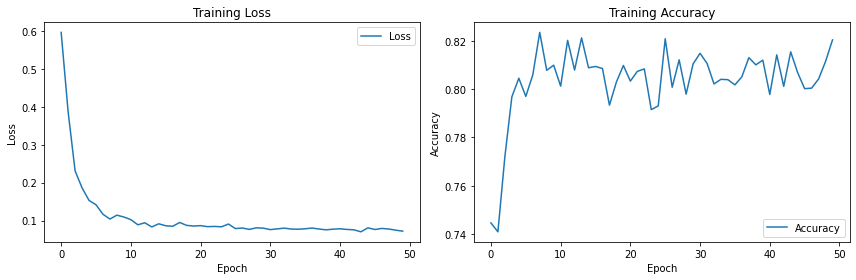

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 538ms/step


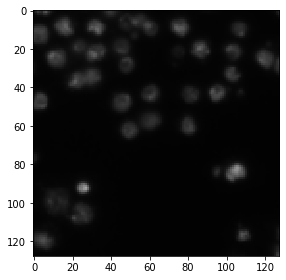

<ipython-input-5-4bfa24972ee5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros((128,128,1),dtype=np.bool)


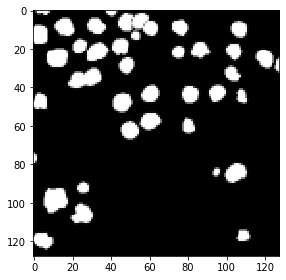

/home/dat.lt19010205/CongDuc/.conda/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


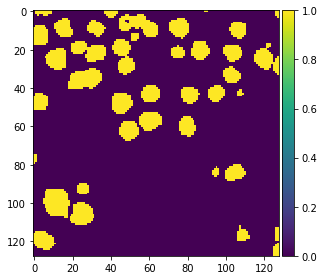

In [11]:
model = load_model('/home/dat.lt19010205/CongDuc/unet/2018/model.h5')
predsTrain = model.predict(np.expand_dims(preProcess(xTrain[100]),axis=0))

predsThreshold = (predsTrain > 0.5).astype(np.uint8)

ix = 100
imshow(preProcess(xTrain[ix]))
plt.show()
imshow(np.squeeze(maskFormation(yTrain[ix])))
plt.show()
imshow(np.squeeze(predsThreshold))
plt.show()

1/1 [==============================] - 0s 168ms/step


<ipython-input-5-4bfa24972ee5>:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros((128,128,1),dtype=np.bool)


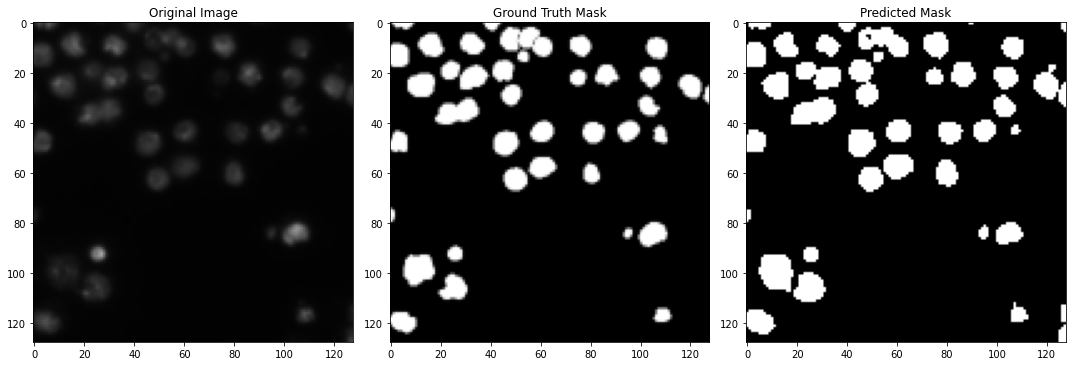

In [ ]:
import matplotlib.pyplot as plt

model = load_model('/home/dat.lt19010205/CongDuc/unet/2018/model.h5')

ix = 100

img = preProcess(xTrain[ix])
pred = model.predict(np.expand_dims(img, axis=0))
pred_thresh = (pred > 0.5).astype(np.uint8)

mask = maskFormation(yTrain[ix])

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('on')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(np.squeeze(mask), cmap='gray')
plt.axis('on')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(np.squeeze(pred_thresh), cmap='gray')
plt.axis('on')

plt.tight_layout()
plt.show()
